In [16]:
import sys
sys.path.insert(0, '..')
sys.path.insert(0, '../..')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as cm
import pandas as pd
import json


import deeptrack as dt

import tensorflow as tf

import logging

logging.disable(logging.WARNING)

In [17]:
# Output type
_OUTPUT_TYPE = "edges"

# Seach radius for the graph edges
radius = 0.01 # change

variables = dt.DummyFeature(
    radius=radius,
    # min_data_size=511,
    # max_data_size=512,
    # batch_size=8,
    output_type=_OUTPUT_TYPE,
    nofframes=10, # change
)

In [18]:
_LOAD_MODEL = False

model = dt.models.gnns.MAGIK(
    dense_layer_dimensions=(64, 96,),   # number of features in each dense encoder layer
    base_layer_dimensions=(96, 96, 96),        # Latent dimension throughout the message passing layers
    number_of_node_features=2,             # Number of node features in the graphs
    number_of_edge_features=1,             # Number of edge features in the graphs
    number_of_edge_outputs=1,              # Number of predicted features
    edge_output_activation="sigmoid",      # Activation function for the output layer
    output_type=_OUTPUT_TYPE,              # Output type. Either "edges", "nodes", or "graph"
)


# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss = 'binary_crossentropy',
    metrics=['accuracy'],
)
model.model.summary()

if _LOAD_MODEL:
    print("Loading model...")
    model.load_weights("../pre-trained-models/MAGIK.h5")

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
node_ide1 (Dense)               (None, None, 64)     192         input_9[0][0]                    
__________________________________________________________________________________________________
layer (Layer)                   multiple             0           node_ide1[0][0]                  
                                                                 edge_ide1[0][0]                  
                                                                 node_ide2[0][0]                  
                                                                 edge_ide2[0][0]            

In [19]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)


def get_annonations(idx, positions):
    annonation = {
        "idx": idx,
        "length": np.shape(positions)[0],
        "coordinates": positions,
    }
    return annonation

In [21]:
from utils import load_video
FRAMES_PATH = "../data/plankton-videos/Plankton1.mp4"
frames = load_video(FRAMES_PATH, end=100)
frames.shape

loading frames: 100%|██████████| 100/100 [00:17<00:00,  5.59it/s]


(100, 1080, 1920, 3)

In [43]:
# json_path = '/Users/harshithbachimanchi/Desktop/sarcoma-project-seg-results/C_7.5HourRunBFandGFPevery3min/detections.json'
# dfs = srt.create_df_sarcoma(
#     path = json_path,
#     scaling=512
# )

In [22]:
DATA_PATH = "../data/plankton-detections-data/lodestar-detections-plankton1.npy"
from utils import create_df_planktons
dfs = create_df_planktons(
    path = DATA_PATH,
    no_frames=[100],
    scaling_x=1080,
    scaling_y=1920,
)

In [23]:
dfs

,centroid-0,centroid-1,frame,solution,set,label
0,0.021127,0.513277,0,0,0,0
1,0.020959,0.968239,0,0,0,0
2,0.021515,0.954192,0,0,0,0
3,0.036856,0.958296,0,0,0,0
4,0.120047,0.488477,0,0,0,0
...,...,...,...,...,...,...
4198,0.899547,0.804170,99,0,0,0
4199,0.922263,0.582537,99,0,0,0
4200,0.937405,0.311198,99,0,0,0
4201,0.969869,0.108264,99,0,0,0


In [24]:
print(dfs["centroid-1"].max(), dfs["centroid-1"].min())
print(dfs["centroid-0"].max(), dfs["centroid-0"].min())

0.9876008987426758 0.00944006045659383
0.9818196614583333 0.01656757460700141


In [25]:
pred, gt, scores, graph = dt.models.gnns.get_predictions(
    dfs, ["centroid"], model, **variables.properties()
) 

Creating graph edges...


100%|██████████| 1/1 [00:24<00:00, 24.15s/it]


In [26]:
edges_df, nodes, _ = dt.models.gnns.df_from_results(pred, gt, scores, graph)

# display the first 10 rows of the dataframe
edges_df.head(10)

,frame_x,frame_y,node_x,node_y,gt,prediction,score,frame_diff
0,0.0,1.0,0.0,40.0,1.0,1.0,0.646981,1.0
1,0.0,1.0,2.0,42.0,1.0,1.0,0.575473,1.0
2,0.0,1.0,6.0,44.0,1.0,1.0,0.712103,1.0
3,0.0,1.0,7.0,43.0,1.0,1.0,0.698515,1.0
4,0.0,1.0,8.0,45.0,1.0,1.0,0.702310,1.0
5,0.0,1.0,9.0,46.0,1.0,1.0,0.694404,1.0
6,0.0,1.0,10.0,47.0,1.0,1.0,0.718018,1.0
7,0.0,1.0,11.0,50.0,1.0,1.0,0.707732,1.0
8,0.0,1.0,12.0,49.0,1.0,1.0,0.741935,1.0
9,0.0,1.0,13.0,54.0,1.0,1.0,0.682337,1.0


In [27]:
traj = dt.models.gnns.get_traj(edges_df, th = 2)

In [29]:
traj

[[[0, 40, 79], array([0.99215686, 0.65241061, 0.37696271, 1.        ])],
 [[6, 44, 84, 121, 161, 199],
  array([0.98698962, 0.53743945, 0.21763937, 1.        ])],
 [[8, 45, 85, 237, 278],
  array([0.86431373, 0.91738562, 0.96653595, 1.        ])],
 [[9, 46, 86, 126, 164, 203, 239],
  array([0.9979085 , 0.92941176, 0.86091503, 1.        ])],
 [[10, 47, 87, 127, 165, 202, 238],
  array([0.98551326, 0.53301038, 0.21259516, 1.        ])],
 [[12,
   49,
   89,
   129,
   167,
   204,
   240,
   284,
   324,
   369,
   415,
   460,
   508,
   553,
   597,
   640,
   677,
   718,
   761,
   839,
   882],
  array([0.80821223, 0.87998462, 0.94783545, 1.        ])],
 [[11, 50, 90, 130], array([0.09019608, 0.39294118, 0.67058824, 1.        ])],
 [[14, 53, 131, 170, 206, 243],
  array([0.99741638, 0.92202999, 0.8466436 , 1.        ])],
 [[57, 135, 175, 212, 247, 293, 332, 378, 424, 471, 519, 561, 647],
  array([1.        , 0.96078431, 0.92156863, 1.        ])],
 [[19, 58, 98, 136, 213, 249, 334],


In [ ]:
import glob
import cv2

import matplotlib.pyplot as plt

# frames = glob.glob("datasets/CellMigDataset/images/*.tif")[0:10]

for f, frame in enumerate(frames):
    # img = cv2.imread(frame, -1)
    img = frame

    fig = plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.text(10, 40, "Frame: " + str(f), fontsize=20, c="white")
    plt.axis("off")

    for i, (t, c) in enumerate(traj):
        detections = nodes[t][(nodes[t, 0] <= f) & (nodes[t, 0] >= f - 10), :]

        if (len(detections) == 0) or (np.max(nodes[t, 0]) < f):
            continue

        plt.plot(detections[:, 2] * 1920, detections[:, 1] * 1080, color = c, linewidth=2)
        plt.scatter(detections[-1, 2] * 1980, detections[-1, 1] * 1080, linewidths=1.5, c = c)
    
    plt.show()

KeyboardInterrupt: 

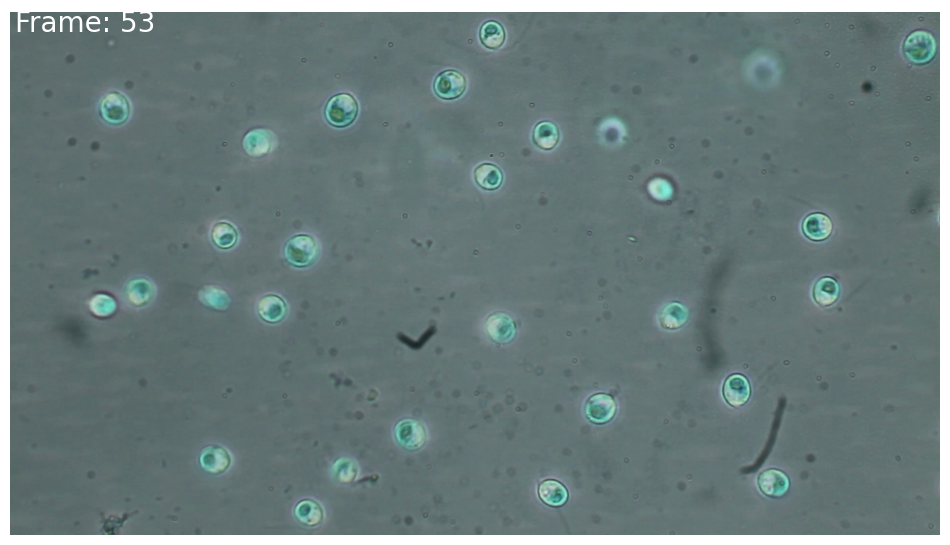

In [24]:
FOLDER_PATH = "../results/"

for frame, v in enumerate(frames):

    fig = plt.figure(figsize=(12, 8))
    plt.imshow(v, cmap='gray')
    plt.text(10, 40, "Frame: " + str(frame), fontsize=20, c="white")
    plt.axis('off')

    for i, (t, c) in enumerate(traj):
        detections = nodes[t][(nodes[t, 0] <= frame) & (nodes[t, 0] >= frame - len(frames)), :]

        if (len(detections) == 0) or (np.max(nodes[t, 0]) < frame):
            continue

        plt.plot(detections[:, 1] * 1080, detections[:, 2] * 1920, color = 'red', linewidth=2)
        #plt.plot(detections[-1, 1] * 1280, detections[-1, 2] * 1024,  marker = 'o', markersize=10, markeredgewidth = 2, markeredgecolor = c) #edgecolors=c)

    plt.savefig(FOLDER_PATH + "_f_" + str(frame) + ".png")
    plt.close(fig)

In [13]:
trajectories = sorted(glob.glob(folder_path), key=os.path.getmtime)

In [14]:
trajectories

['/Users/harshithbachimanchi/Desktop/sarcoma-project-seg-results/C_7.5HourRunBFandGFPevery3min/traces/']

In [20]:
import imageio

trajectories = sorted(glob.glob(folder_path), key=os.path.getmtime)

for i, folder in enumerate(trajectories):
    frames = glob.glob(folder +"/*.png")
    frames.sort(key=os.path.getmtime)

    writer = imageio.get_writer(
        folder_path+ 'trace_video' + ".mov", 
        fps=10,  codec='mjpeg', quality=10#, pixelformat='yuvj444p'
    )

    for frame in frames:
        # read image
        img = cv2.imread(frame)
        writer.append_data(img)
    
    writer.close()

Incompatible pixel format 'yuv420p' for codec 'mjpeg', auto-selecting format 'yuvj420p'
[swscaler @ 0x7fa48e2c6000] deprecated pixel format used, make sure you did set range correctly
